# RLbook2020-2.5 Tracking a nonstationary problem
Update based on RLbook-2.4:
* Add input parameter to control the method of updating Q

Update based on RLbook-2.3-ten-armed-testbed:
* Package smooth() and movingaverage() into utilities.py
* Q update in accordance to 2.4-incremental implementation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utilities as util

%load_ext autoreload
%autoreload 2

%matplotlib inline

In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

## k_armed_bandit_one_run()接口扩张

追加QUpdtAlgo和alpha两个参数，以同时支持sample-average method和exponential-recency-weighted average两种Q值估计方法，并且支持stationary vs non-stationary evaluation

函数实现的更新有以下几点： 

(1) 追加了行动价值估计的'exponential recency-weighted average'算法的支持

(2) 在non-stationary环境中，

(2-1)qstar在内部先初始化为1/K for each action；

(2-2)在每一步之后，每个行动的qstar叠加一个随机值，随机值从从零均值，标准偏差为0.01的正态分布中抽取

(2-3)由于qstar是每一步都随机变化的，所以optAct也需要每一步进行评估

In [2]:
def k_armed_bandit_one_run(qstar,epsilon,nStep,QUpdtAlgo='sample_average',alpha=0, stationary=True):
    """
    One run of K-armed bandit simulation.
    Input:
        qstar:     Mean reward for each candition actions
        epsilon:   Epsilon value for epsilon-greedy algorithm
        nStep;     The number of steps for simulation
        QUpdtAlgo: The algorithm for updating Q value--'sample_average','exp_decaying'
        alpha:     step-size in case of 'exp_decaying'
    Output:
        a[t]: action series for each step in one run
        r[t]: reward series for each step in one run
        Q[k]: reward sample average up to t-1 for action[k]
        aNum[k]: The number of being selected for action[k]
        optRatio[t]: Ration of optimal action being selected over tim
    """
    
    K     = len(qstar)
    Q     = np.zeros(K)
    a     = np.zeros(nStep+1,dtype='int') # Item#0 for initialization
    aNum  = np.zeros(K,dtype='int')       # Record the number of action#k being selected
    
    r     = np.zeros(nStep+1)             # Item#0 for initialization

    if stationary == False:
        qstar = np.ones(K)/K                 # qstart initialized to 1/K for all K actions    
    
    optCnt   = 0
    optRatio = np.zeros(nStep+1,dtype='float') # Item#0 for initialization

    for t in range(1,nStep+1):

        #0. For non-stationary environment, optAct also changes over time.Hence, move to inside the loop.
        optAct   = np.argmax(qstar)
        #1. action selection
        tmp = np.random.uniform(0,1)
        #print(tmp)
        if tmp < epsilon: # random selection
            a[t] = np.random.choice(np.arange(K))
            #print('random selection: a[{0}] = {1}'.format(t,a[t]))
        else:             # greedy selection
            #选择Q值最大的那个，当多个Q值并列第一时，从中任选一个--但是如何判断有多个并列第一的呢？
            #对Q进行random permutation处理后再找最大值可以等价地解决这个问题
            p = np.random.permutation(K)
            a[t] = p[np.argmax(Q[p])]
            #print('greedy selection: a[{0}] = {1}'.format(t,a[t]))

        aNum[a[t]] = aNum[a[t]] + 1

        #2. reward: draw from the pre-defined probability distribution    
        r[t] = np.random.randn() + qstar[a[t]]        

        #3.Update Q of the selected action - #2.4 Incremental Implementation
        # Q[a[t]] = (Q[a[t]]*(aNum[a[t]]-1) + r[t])/aNum[a[t]]    
        if QUpdtAlgo == 'sample_average':
            Q[a[t]] = Q[a[t]] + (r[t]-Q[a[t]])/aNum[a[t]]    
        elif QUpdtAlgo == 'exp_decaying':
            Q[a[t]] = Q[a[t]] + (r[t]-Q[a[t]])*alpha
        
        #4. Optimal Action Ratio tracking
        #print(a[t], optAct)
        if a[t] == optAct:
            optCnt = optCnt + 1
        optRatio[t] = optCnt/t

        #5. Random walk of qstar simulating non-stationary environment
        # Take independent random walks (say by adding a normally distributed increment with mean 0
        # and standard deviation 0.01 to all the q⇤(a) on each step).   
        if stationary == False:        
            qstar = qstar + np.random.randn(K)*0.01 # Standard Deviation = 0.01
            #print('t={0}, qstar={1}, sum={2}'.format(t,qstar,np.sum(qstar)))
        
    return a,aNum,r,Q,optRatio

The true value $q_*(a)$ of
each of the ten actions was selected according to a normal distribution with mean zero and unit
variance.

The actual rewards were selected according to a mean $q_*(a)$, unit-variance
normal distribution

In [3]:
nStep = 10000
epsilon = 0.1
qstar   = np.random.randn(10)
a,aNum,r,Q,optRatio = k_armed_bandit_one_run(qstar,epsilon,nStep,'sample_average')

## Q value vs qstar

Q[k]代表所有采取行动k的reward的平均，而qstar[k]代表行动k的reward的数学期望。当$nStep\to\infty$时应该有$Q[k]\to q_*[k]$.

## Number of actions vs qstar

aNum[k]代表所有采取action#k被选择的次数，而qstar[k]代表action#k的reward的数学期望。当$nStep\to\infty$时理论上来说应该有reward期望越高的行动被选择的次数越多。但是与$Q[k]\propto q_*[k]$不同，各action被选择的次数应该遵循马太效应，即最后应该集中在最高q值的action或最高的几个actions上
不过从实验结果来看，并不一定是q值最高的action被选择次数最高--特别是当有相近q值的actions时

Text(0.5, 1.0, 'qstar vs aNum')

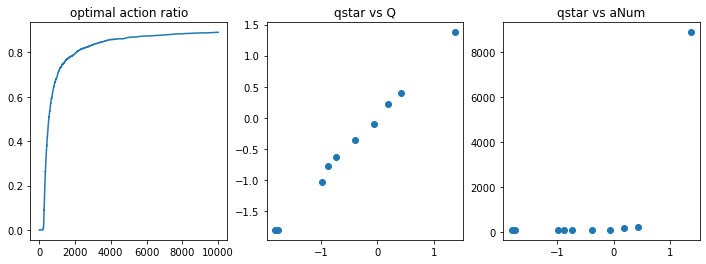

In [4]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(optRatio)
ax[1].scatter(qstar,Q)
ax[2].scatter(qstar,aNum)
ax[0].set_title('optimal action ratio')
ax[1].set_title('qstar vs Q')
ax[2].set_title('qstar vs aNum')

## 再现之前的实验结果

In [5]:
nStep = 1000
nRun  = 2000
K     = 10

r_0p0   = np.zeros((nRun,nStep+1))
r_0p1   = np.zeros((nRun,nStep+1))
r_0p01  = np.zeros((nRun,nStep+1))
optRatio_0p0 = np.zeros((nRun,nStep+1))
optRatio_0p1 = np.zeros((nRun,nStep+1))
optRatio_0p01= np.zeros((nRun,nStep+1))

for run in range(nRun):
    print('.',end='')
    if run%100==99:        
        print('run = ',run+1)
    
    qstar   = np.random.randn(10) 
    a,aNum,r_0p0[run,:],Q,optRatio_0p0[run,:] = k_armed_bandit_one_run(qstar,epsilon=0,nStep=nStep)
    a,aNum,r_0p1[run,:],Q,optRatio_0p1[run,:] = k_armed_bandit_one_run(qstar,epsilon=0.1,nStep=nStep)
    a,aNum,r_0p01[run,:],Q,optRatio_0p01[run,:] = k_armed_bandit_one_run(qstar,epsilon=0.01,nStep=nStep)


....................................................................................................run =  100
....................................................................................................run =  200
....................................................................................................run =  300
....................................................................................................run =  400
....................................................................................................run =  500
....................................................................................................run =  600
....................................................................................................run =  700
....................................................................................................run =  800
....................................................................................................run =  900
.

## Average Reward and optimal action

Optimal Action是指对应于$q_*$中期望值最高的那个。In the above simulation, $q_*$ is re-initialized for each run. Hence, in simulation, the optimal action counting must be tracked in each run in a cumulative way.

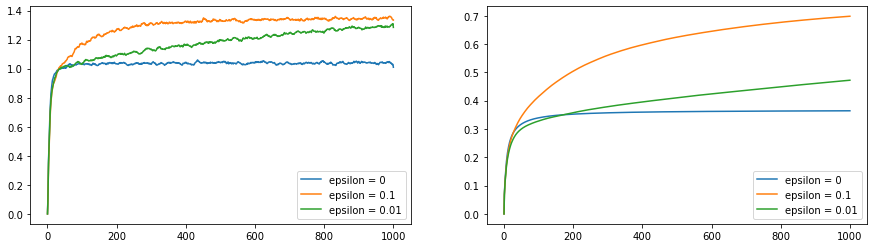

In [6]:
rEnsembleMean_0p0 = np.mean(r_0p0,axis=0)
rEnsembleMean_0p1 = np.mean(r_0p1,axis=0)
rEnsembleMean_0p01 = np.mean(r_0p01,axis=0)

optRatioEnsembleMean_0p0 = np.mean(optRatio_0p0,axis=0)
optRatioEnsembleMean_0p1 = np.mean(optRatio_0p1,axis=0)
optRatioEnsembleMean_0p01 = np.mean(optRatio_0p01,axis=0)

plt.figure(figsize=(15,4))
ax1=plt.subplot(1, 2, 1)

ax1.plot(util.smooth(rEnsembleMean_0p0,11))
ax1.plot(util.smooth(rEnsembleMean_0p1,11))
ax1.plot(util.smooth(rEnsembleMean_0p01,11))
ax1.legend(['epsilon = 0','epsilon = 0.1','epsilon = 0.01'])

ax2=plt.subplot(1, 2, 2)
ax2.plot(util.smooth(optRatioEnsembleMean_0p0,11))
ax2.plot(util.smooth(optRatioEnsembleMean_0p1,11))
ax2.plot(util.smooth(optRatioEnsembleMean_0p01,11))
ax2.legend(['epsilon = 0','epsilon = 0.1','epsilon = 0.01'])

## Comparison between different Q-updating methods in stationary and non-stationary environement
* 仿真控制参数
    * number of steps = 10000
    * number of run = 2000
    * K: The number of candidate actions, 10   
    * epsilon = 0.1
    * alpha = 0.1 for exponential-recency decaying filtering
    
Note!!!: qstar randonmization should be put inside the outer loop to make each run representing a different bandit problem.

### Stationary environment

In [7]:
nStep  = 1000
nRun   = 1000
K      = 10
alpha  = 0.1
r_smpaver = np.zeros((nRun,nStep+1))
optRatio_smpaver  = np.zeros((nRun,nStep+1))

r_exp = np.zeros((nRun,nStep+1))
optRatio_exp  = np.zeros((nRun,nStep+1))

for run in range(nRun):
    print('.',end='')
    if run%100==99:        
        print('run = ',run+1)
    
    qstar   = np.random.randn(K) 
    a_smpaver,aNum_smpaver,r_smpaver[run,:],Q,optRatio_smpaver[run,:] = k_armed_bandit_one_run(qstar,0.1,nStep)
    a_exp,aNum_exp,r_exp[run,:],Q,optRatio_exp[run,:] = k_armed_bandit_one_run(qstar,0.1,nStep,'exp_decaying',alpha)


....................................................................................................run =  100
....................................................................................................run =  200
....................................................................................................run =  300
....................................................................................................run =  400
....................................................................................................run =  500
....................................................................................................run =  600
....................................................................................................run =  700
....................................................................................................run =  800
....................................................................................................run =  900
.

Text(0.5, 1.0, 'ensemble mean optimal ratio')

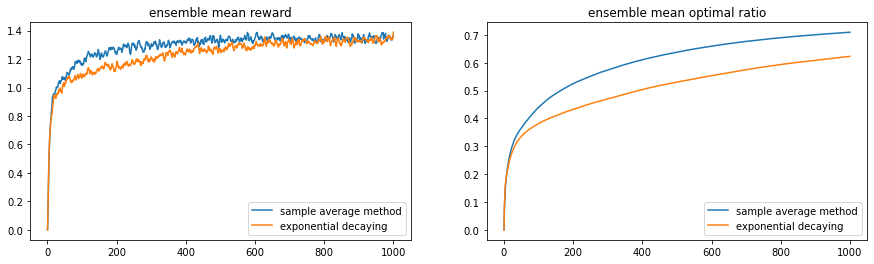

In [8]:
rEnsembleMean_smpaver = np.mean(r_smpaver,axis=0)
optRatioEnsembleMean_smpaver = np.mean(optRatio_smpaver,axis=0)

rEnsembleMean_exp = np.mean(r_exp,axis=0)
optRatioEnsembleMean_exp = np.mean(optRatio_exp,axis=0)

fig,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot(util.smooth(rEnsembleMean_smpaver,5))
ax[0].plot(util.smooth(rEnsembleMean_exp,5))
ax[1].plot(util.smooth(optRatioEnsembleMean_smpaver,5))
ax[1].plot(util.smooth(optRatioEnsembleMean_exp,5))
ax[0].legend(['sample average method','exponential decaying'])
ax[1].legend(['sample average method','exponential decaying'])
ax[0].set_title('ensemble mean reward')
ax[1].set_title('ensemble mean optimal ratio')

### Non-stationary environment

In [9]:
# k_armed_bandit_one_run run-trial in non-stationary environment. For debug
nStep  = 100
K      = 10
alpha  = 0.1
r_smpaver = np.zeros((nRun,nStep+1))
optRatio_smpaver  = np.zeros((nRun,nStep+1))

r_exp = np.zeros((nRun,nStep+1))
optRatio_exp  = np.zeros((nRun,nStep+1))

print('.',end='')
if run%100==99:        
    print('run = ',run+1)

qstar   = np.random.randn(K) 
a_exp,aNum_exp,r_exp[run,:],Q,optRatio_exp[run,:] = k_armed_bandit_one_run(qstar,0.1,nStep,'exp_decaying',alpha,False)


.run =  1000


In [10]:
nStep  = 20000
nRun   = 1000
K      = 10
alpha  = 0.1
r_smpaver = np.zeros((nRun,nStep+1))
optRatio_smpaver  = np.zeros((nRun,nStep+1))

r_exp = np.zeros((nRun,nStep+1))
optRatio_exp  = np.zeros((nRun,nStep+1))

for run in range(nRun):
    print('.',end='')
    if run%100==99:        
        print('run = ',run+1)
    
    qstar   = np.random.randn(K) 
    a_smpaver,aNum_smpaver,r_smpaver[run,:],Q,optRatio_smpaver[run,:] = k_armed_bandit_one_run(qstar,0.1,nStep,'sample_average',alpha,False)
    a_exp,aNum_exp,r_exp[run,:],Q,optRatio_exp[run,:] = k_armed_bandit_one_run(qstar,0.1,nStep,'exp_decaying',alpha,False)

....................................................................................................run =  100
....................................................................................................run =  200
....................................................................................................run =  300
....................................................................................................run =  400
....................................................................................................run =  500
....................................................................................................run =  600
....................................................................................................run =  700
....................................................................................................run =  800
....................................................................................................run =  900
.

Text(0.5, 1.0, 'ensemble mean optimal ratio')

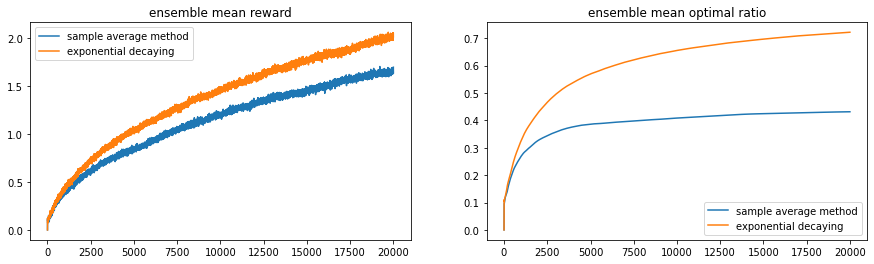

In [11]:
rEnsembleMean_smpaver = np.mean(r_smpaver,axis=0)
optRatioEnsembleMean_smpaver = np.mean(optRatio_smpaver,axis=0)

rEnsembleMean_exp = np.mean(r_exp,axis=0)
optRatioEnsembleMean_exp = np.mean(optRatio_exp,axis=0)

fig,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot(util.smooth(rEnsembleMean_smpaver,5))
ax[0].plot(util.smooth(rEnsembleMean_exp,5))
ax[1].plot(util.smooth(optRatioEnsembleMean_smpaver,5))
ax[1].plot(util.smooth(optRatioEnsembleMean_exp,5))
ax[0].legend(['sample average method','exponential decaying'])
ax[1].legend(['sample average method','exponential decaying'])
ax[0].set_title('ensemble mean reward')
ax[1].set_title('ensemble mean optimal ratio')

## Observation


# Upper Confidence Bound

$A(t) = argmax_{a}\left[Q_t(a) + c\sqrt{\frac{ln(t)}{N_t(a)}}\right]$